In [166]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

import numpy as np
import pandas as pd
from datetime import datetime
import pyodbc
import warnings 
warnings.filterwarnings("ignore")
import os
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Users\chiehlinchen\Desktop\msj.ttf',size=14)
# sns.set(font=myfont.get_family(), rc={'figure.figsize':(5,4)}, font_scale= 2)
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['axes.facecolor']='whitesmoke'

In [75]:
ls2022 = os.listdir(r"\\192.168.1.230\新金部\07個人\larryx30\買進\2022")

In [124]:
ls2023 = os.listdir(r"\\192.168.1.230\新金部\07個人\larryx30\買進")
ls2023.pop(0)
ls2023 = ls2023[:-44]

In [146]:
關鍵點買入部位 = pd.DataFrame()
融資買入部位 = pd.DataFrame()
for name in ls2022:
    數據讀取 = pd.read_excel("\\\\192.168.1.230\\新金部\\07個人\\larryx30\\買進\\2022\\"+name,index_col=0)
    關鍵點讀取 = pd.DataFrame(數據讀取['關鍵點買進'].dropna().astype(int).astype(str)).assign(日期 = name[6:-5])[['日期','關鍵點買進']]
    融資讀取 = pd.DataFrame(數據讀取['融資買進'].dropna().astype(int).astype(str)).assign(日期 = name[6:-5])[['日期','融資買進']]
    關鍵點買入部位 = pd.concat([關鍵點買入部位,關鍵點讀取])
    融資買入部位 = pd.concat([融資買入部位,融資讀取])

In [147]:
for name in ls2023:
    數據讀取 = pd.read_excel("\\\\192.168.1.230\\新金部\\07個人\\larryx30\\買進\\"+name,index_col=0)
    關鍵點讀取 = pd.DataFrame(數據讀取['關鍵點買進'].dropna().astype(int).astype(str)).assign(日期 = name[6:-5])[['日期','關鍵點買進']]
    融資讀取 = pd.DataFrame(數據讀取['融資買進'].dropna().astype(int).astype(str)).assign(日期 = name[6:-5])[['日期','融資買進']]
    關鍵點買入部位 = pd.concat([關鍵點買入部位,關鍵點讀取])
    融資買入部位 = pd.concat([融資買入部位,融資讀取])

In [148]:
關鍵點買入部位['日期'] = pd.to_datetime(關鍵點買入部位['日期'])
融資買入部位['日期'] = pd.to_datetime(融資買入部位['日期'])
關鍵點買入部位 = 關鍵點買入部位.rename(columns = {'關鍵點買進':'股票代號'})
融資買入部位 = 融資買入部位.rename(columns = {'融資買進':'股票代號'})

In [133]:
class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332"),'StrategyData': ('10.14.106.11','StrategyData','cc1102','cc1102')}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df

    
    @staticmethod
    def make_TCRI():
        df ="""SELECT  [STOCKID]
                      ,[TCRI]
                  FROM [StrategyData].[dbo].[TCRI]"""
        return df

    @staticmethod
    def make_inday():
        df ="""SELECT [日期]
                    ,[股票代號]

                FROM [X01].[dbo].[日當日沖銷交易] where 日期 >= '20200101'"""
        return df

   

    @staticmethod
    def make_stock_returns():
        df ="""SELECT [日期]
                ,[股票代號]
                ,[開盤價]
                ,[收盤價]
                ,[漲幅(%)]
                ,[成交金額(千)]
            FROM [X01].[dbo].[日收盤還原表排行] where 日期 >= '20200101'"""
        return df
    

In [56]:
Sql_Base = get_df()
Sql_Base.db_connect('X01')

Sql_Base.querys['stock_returns'] = get_df.make_stock_returns()
stock_returns = Sql_Base.load_data('stock_returns')
stock_returns['日期'] = pd.to_datetime(stock_returns['日期'])
stock_returns = stock_returns.rename(columns = {'日期':'datetime','股票代號':'instrument'})
stock_returns = stock_returns.sort_values(by = ['instrument','datetime'])
stock_returns = stock_returns.reset_index(drop = True)
stock_returns['漲幅(%)'] = stock_returns['漲幅(%)']/100
stock_returns['開盤價漲幅'] = stock_returns.groupby(['instrument']).開盤價.pct_change()
stock_returns['五日成交金額平均'] = list(stock_returns.groupby('instrument').rolling(5)['成交金額(千)'].mean())
stock_returns = stock_returns.rename(columns = {'datetime':'日期','instrument':'股票代號'})
stock_returns['當沖損益'] = (stock_returns['收盤價']- stock_returns['開盤價'])/stock_returns['開盤價']

#可當沖數據
Sql_Base.querys['可當沖標的'] = get_df.make_inday()
inday = Sql_Base.load_data('可當沖標的')
inday['日期'] = pd.to_datetime(inday['日期'])
inday['是否可當沖'] = 1


Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [149]:
關鍵點買入部位 = 關鍵點買入部位.merge(inday,on = ['日期','股票代號'],how = 'left').dropna().drop(columns = '是否可當沖')
融資買入部位 = 融資買入部位.merge(inday,on = ['日期','股票代號'],how = 'left').dropna().drop(columns = '是否可當沖')

In [150]:
關鍵點買入部位 = 關鍵點買入部位.merge(stock_returns[['日期','股票代號','當沖損益']],on = ['日期','股票代號'],how = 'left')
融資買入部位 = 融資買入部位.merge(stock_returns[['日期','股票代號','當沖損益']],on = ['日期','股票代號'],how = 'left')

In [152]:
關鍵點買入部位 = 關鍵點買入部位.rename(columns = {'當沖損益':'當沖損益(不加成本)'})
關鍵點買入部位['當沖損益(加成本0.15%)']  = 關鍵點買入部位['當沖損益(不加成本)']-0.0015
關鍵點買入部位['當沖損益(加成本0.335%)']  = 關鍵點買入部位['當沖損益(不加成本)']-0.00335
關鍵點買入部位['當沖損益(加成本0.435%)']  = 關鍵點買入部位['當沖損益(不加成本)']-0.00435

In [162]:
融資買入部位 = 融資買入部位.rename(columns = {'當沖損益':'當沖損益(不加成本)'})
融資買入部位['當沖損益(加成本0.15%)']  = 融資買入部位['當沖損益(不加成本)']-0.0015
融資買入部位['當沖損益(加成本0.335%)']  = 融資買入部位['當沖損益(不加成本)']-0.00335
融資買入部位['當沖損益(加成本0.435%)']  = 融資買入部位['當沖損益(不加成本)']-0.00435

In [158]:
關鍵點買入部位_day = 關鍵點買入部位.groupby('日期').agg({'當沖損益(加成本0.15%)':'mean', '當沖損益(加成本0.335%)': 'mean', '當沖損益(加成本0.435%)':'mean'})
關鍵點買入部位_day['累積當沖損益(加成本0.15%)'] = 關鍵點買入部位_day['當沖損益(加成本0.15%)'].cumsum()
關鍵點買入部位_day['累積當沖損益(加成本0.335%)'] = 關鍵點買入部位_day['當沖損益(加成本0.335%)'].cumsum()
關鍵點買入部位_day['累積當沖損益(加成本0.435%)'] = 關鍵點買入部位_day['當沖損益(加成本0.435%)'].cumsum()

In [163]:
融資買入部位_day = 融資買入部位.groupby('日期').agg({'當沖損益(加成本0.15%)':'mean', '當沖損益(加成本0.335%)': 'mean', '當沖損益(加成本0.435%)':'mean'})
融資買入部位_day['累積當沖損益(加成本0.15%)'] = 融資買入部位_day['當沖損益(加成本0.15%)'].cumsum()
融資買入部位_day['累積當沖損益(加成本0.335%)'] = 融資買入部位_day['當沖損益(加成本0.335%)'].cumsum()
融資買入部位_day['累積當沖損益(加成本0.435%)'] = 融資買入部位_day['當沖損益(加成本0.435%)'].cumsum()

**<font  size=6>關鍵點</font>**

**<font  size=5>勝率</font>**

In [169]:
pd.concat([pd.DataFrame.from_dict({'勝率':len(關鍵點買入部位[關鍵點買入部位['當沖損益(加成本0.15%)']>0])/len(關鍵點買入部位)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'勝率':len(關鍵點買入部位[關鍵點買入部位['當沖損益(加成本0.335%)']>0])/len(關鍵點買入部位)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'勝率':len(關鍵點買入部位[關鍵點買入部位['當沖損益(加成本0.435%)']>0])/len(關鍵點買入部位)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,勝率
勝率(加成本0.15%),0.399151
勝率(加成本0.335%),0.361642
勝率(加成本0.435%),0.336872


In [171]:
pd.concat([pd.DataFrame.from_dict({'多單每日平均勝率':len(關鍵點買入部位_day[關鍵點買入部位_day['當沖損益(加成本0.15%)']>0])/len(關鍵點買入部位_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(關鍵點買入部位_day[關鍵點買入部位_day['當沖損益(加成本0.335%)']>0])/len(關鍵點買入部位_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(關鍵點買入部位_day[關鍵點買入部位_day['當沖損益(加成本0.435%)']>0])/len(關鍵點買入部位_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,多單每日平均勝率
勝率(加成本0.15%),0.397163
勝率(加成本0.335%),0.347518
勝率(加成本0.435%),0.297872


**<font  size=5>每日每股損益分配</font>**

<Axes: ylabel='Frequency'>

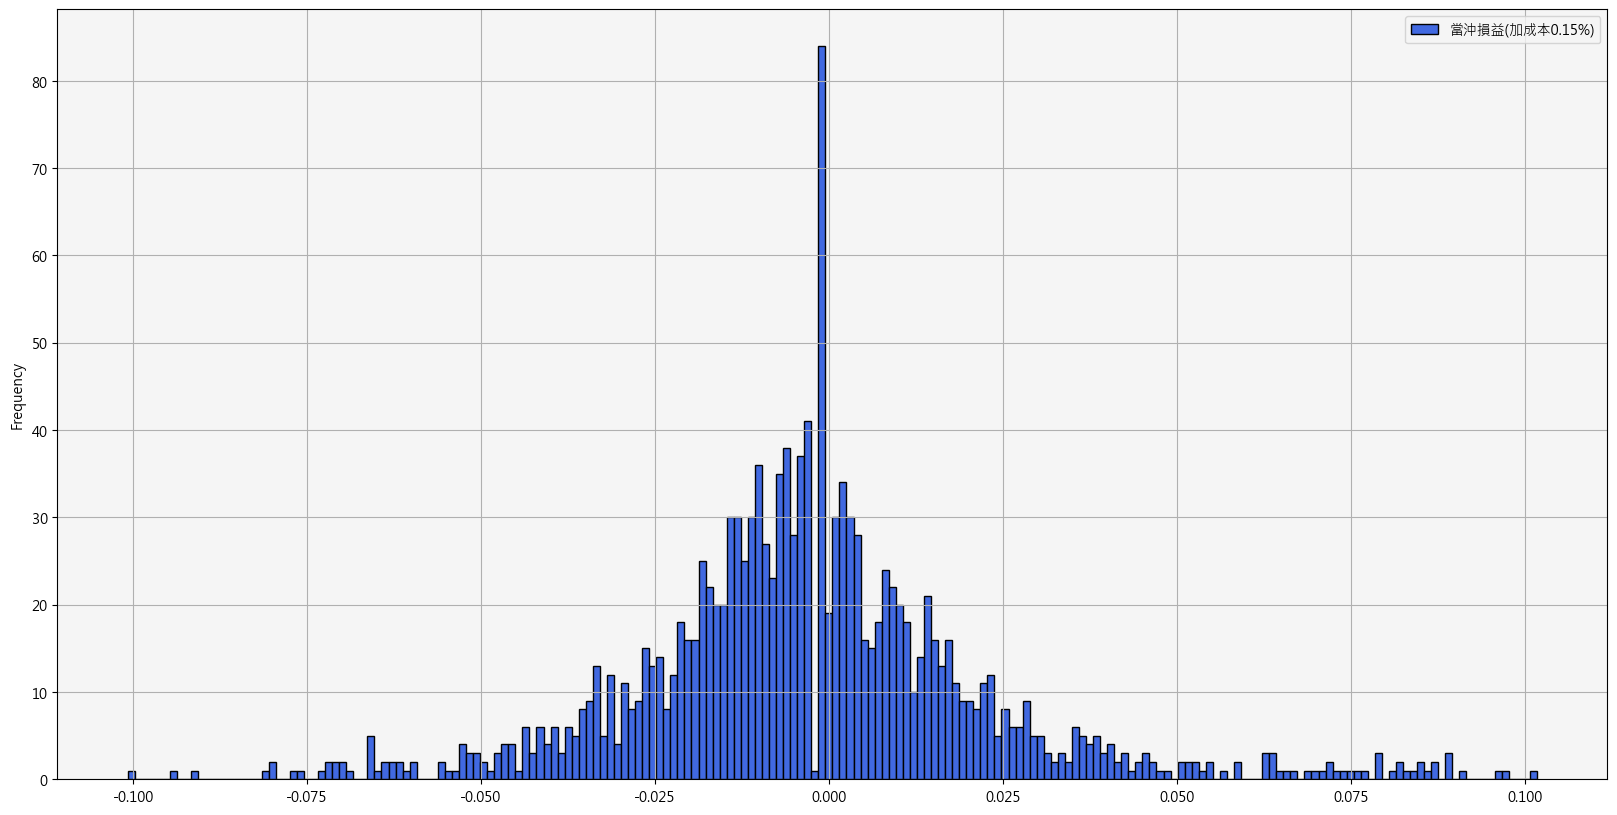

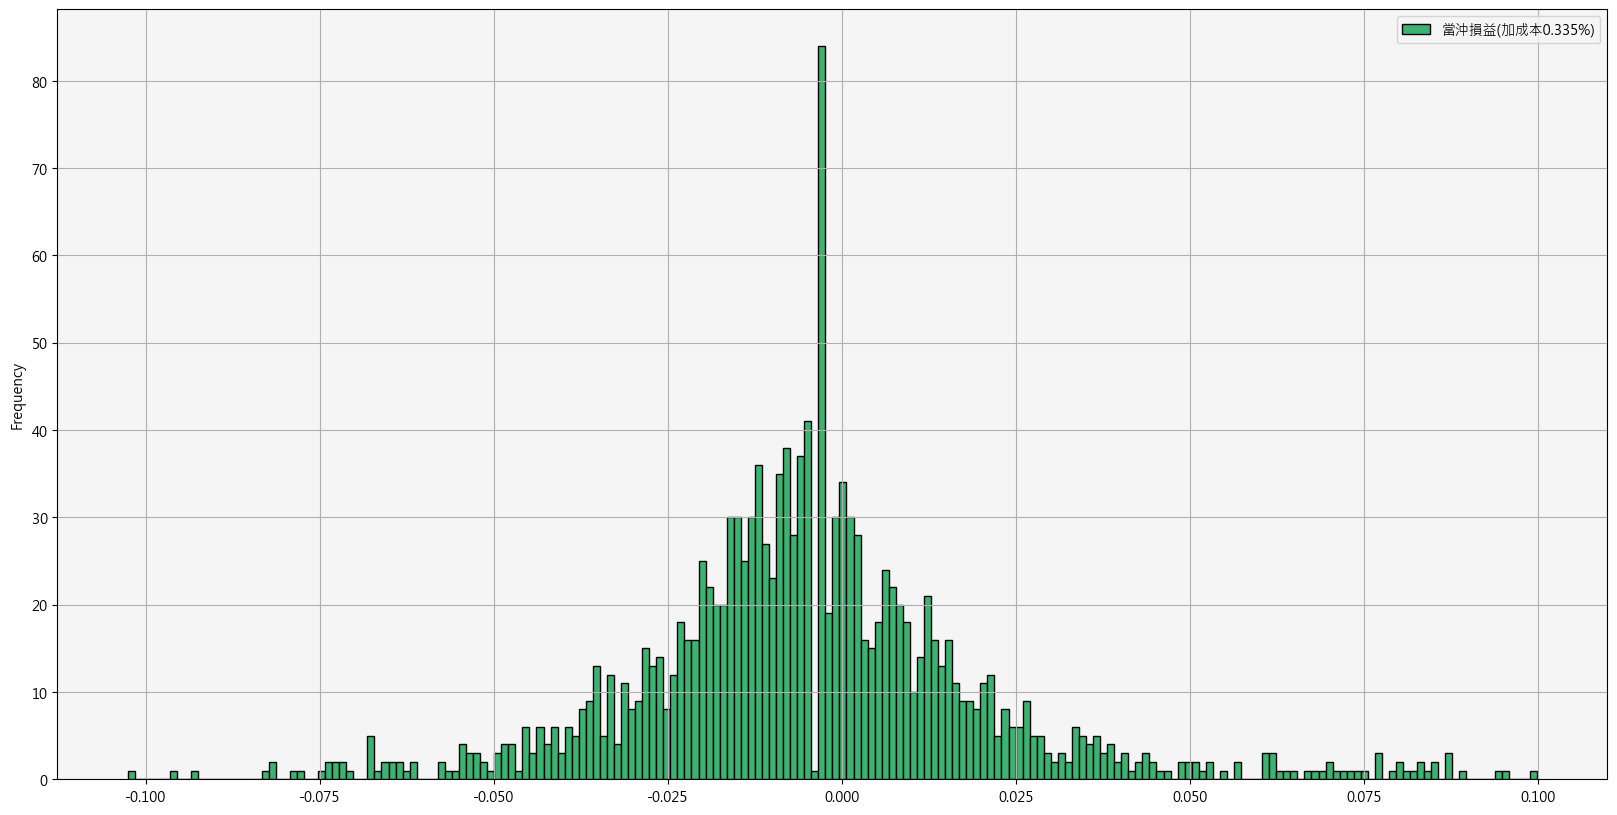

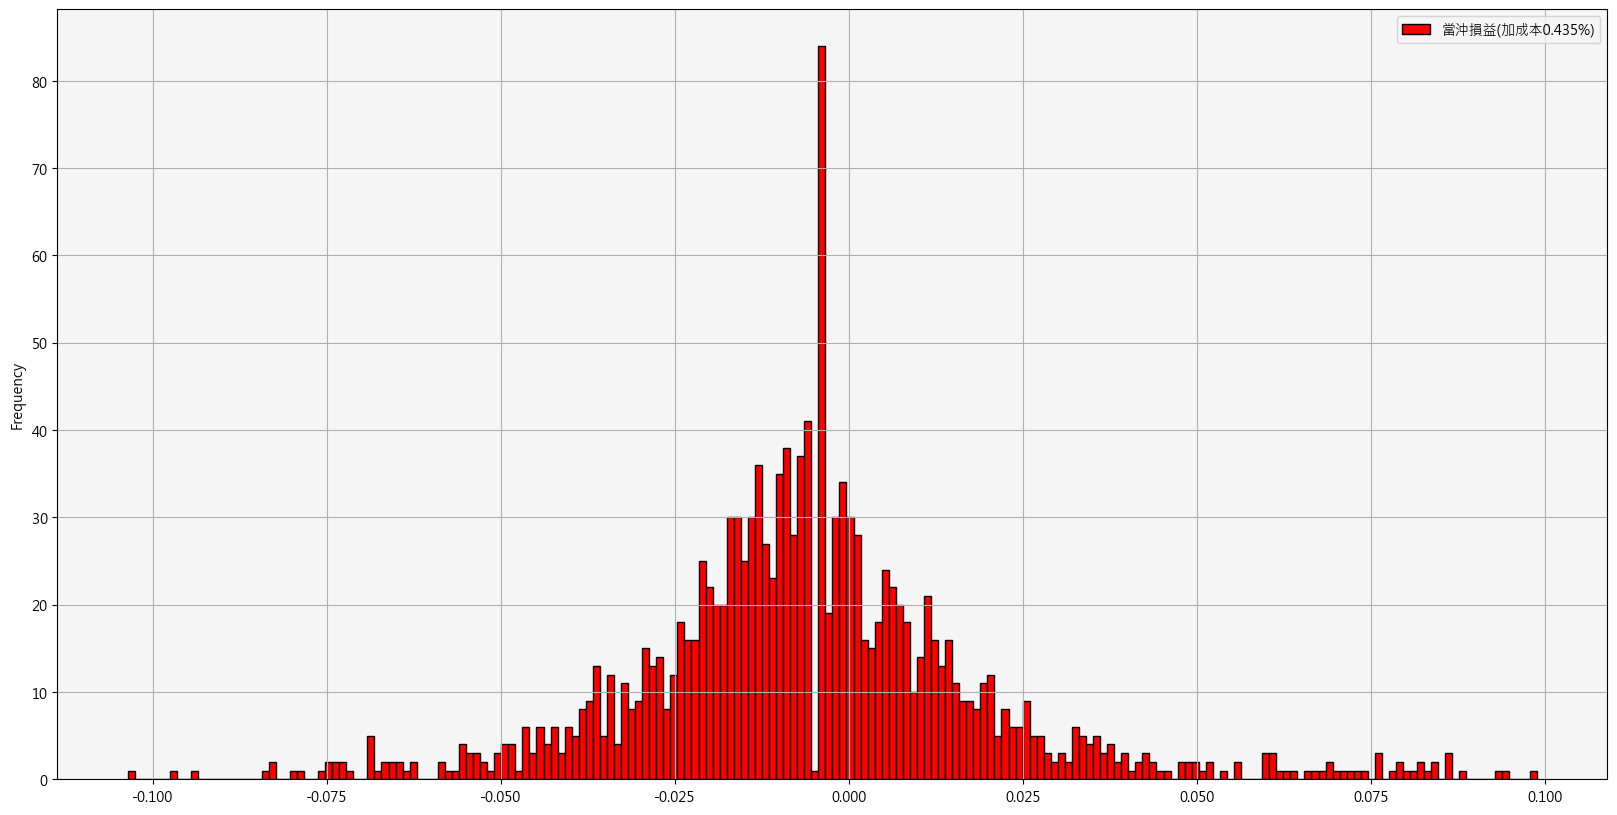

In [172]:
關鍵點買入部位[['當沖損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
關鍵點買入部位[['當沖損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
關鍵點買入部位[['當沖損益(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'red',figsize = (20,10),bins=200,grid = True)

**<font  size=5>每日損益分配</font>**

<Axes: ylabel='Frequency'>

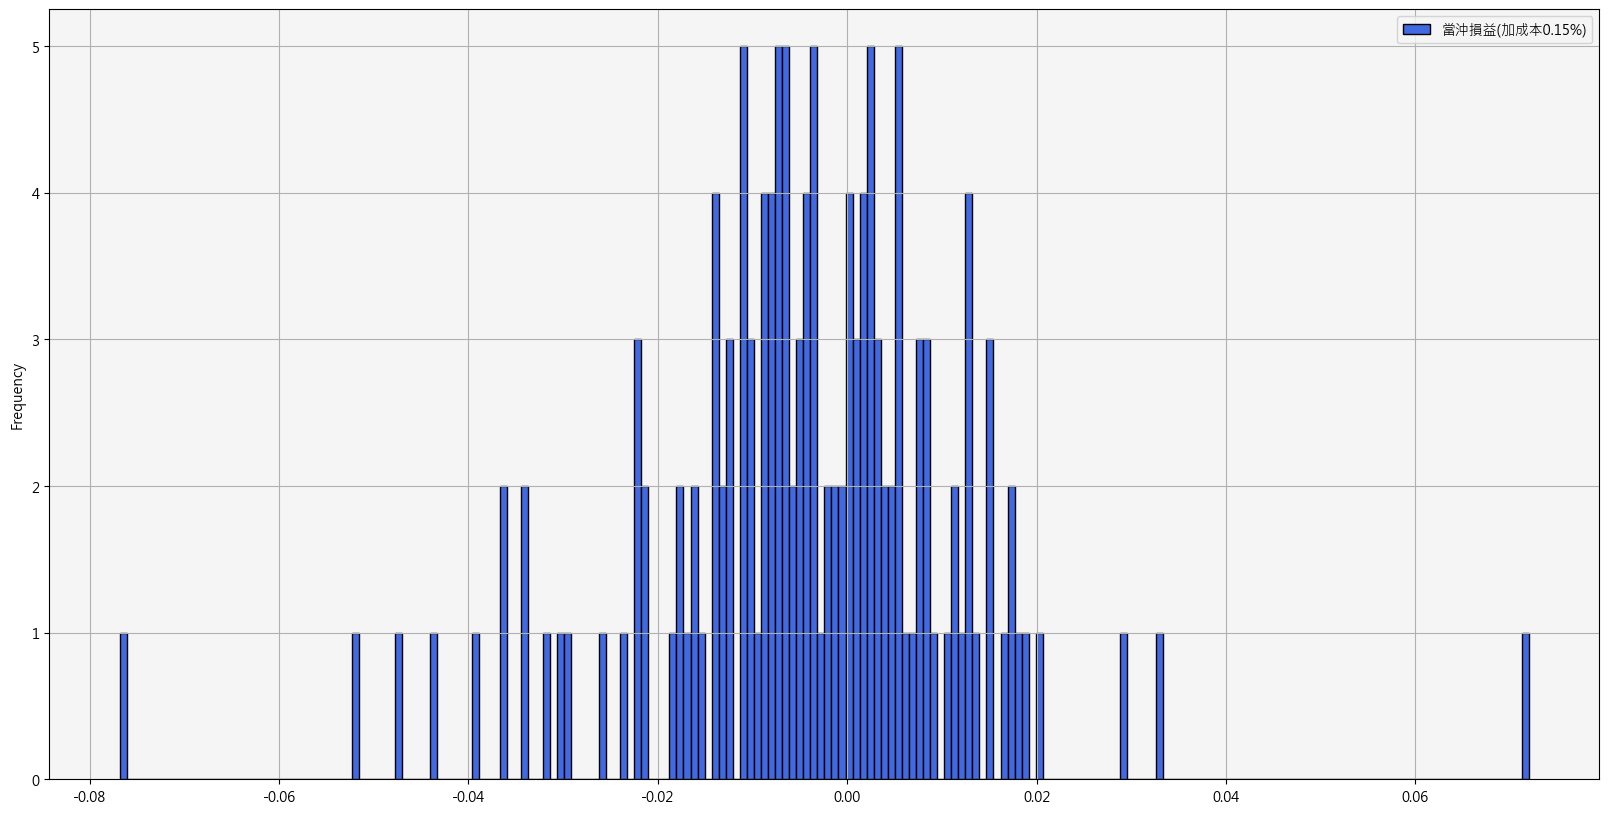

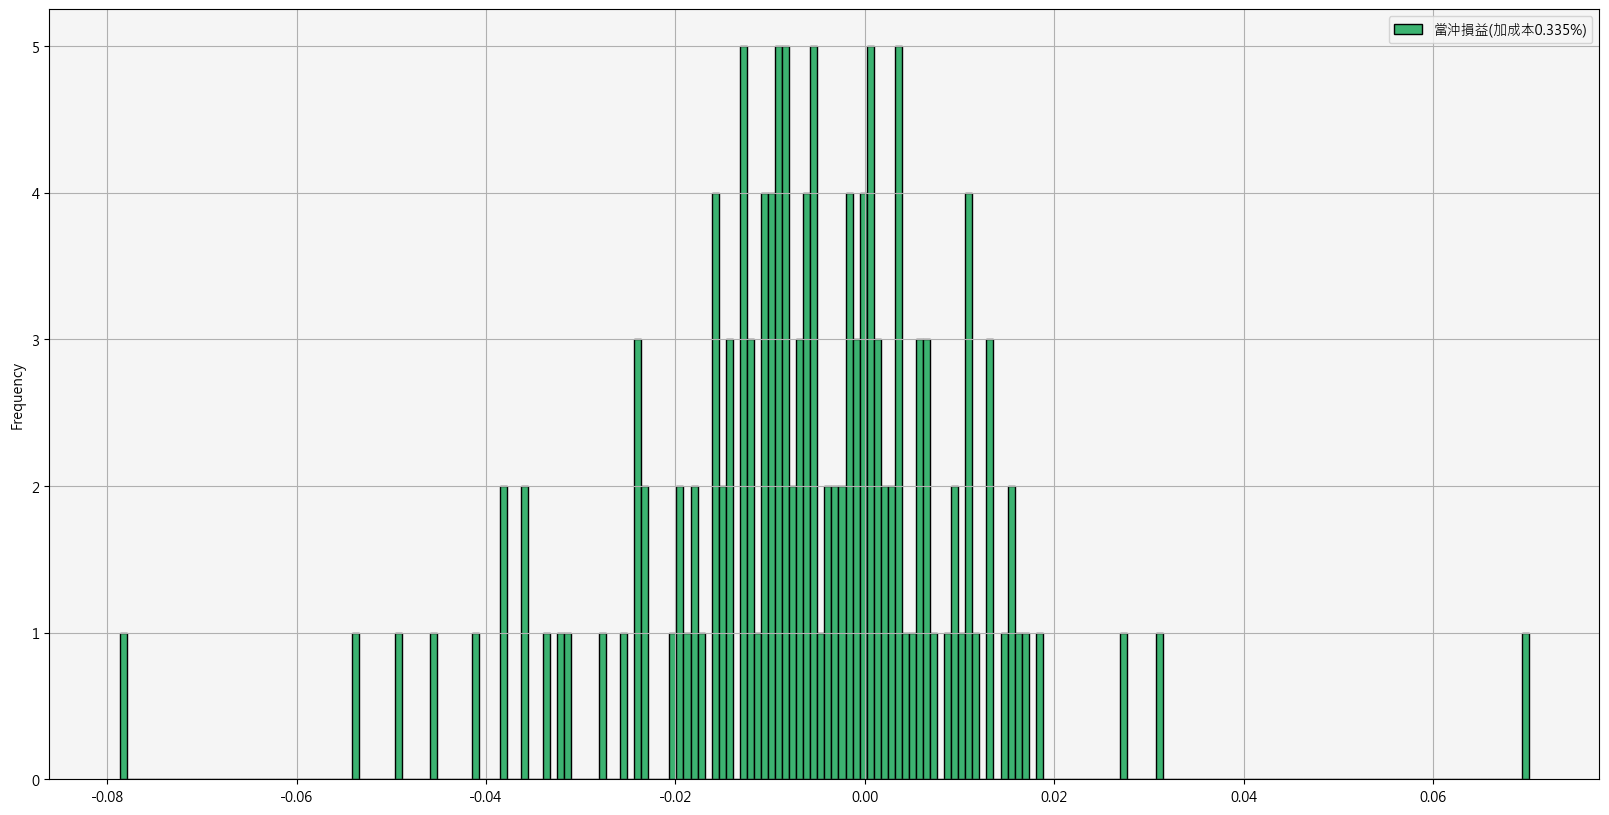

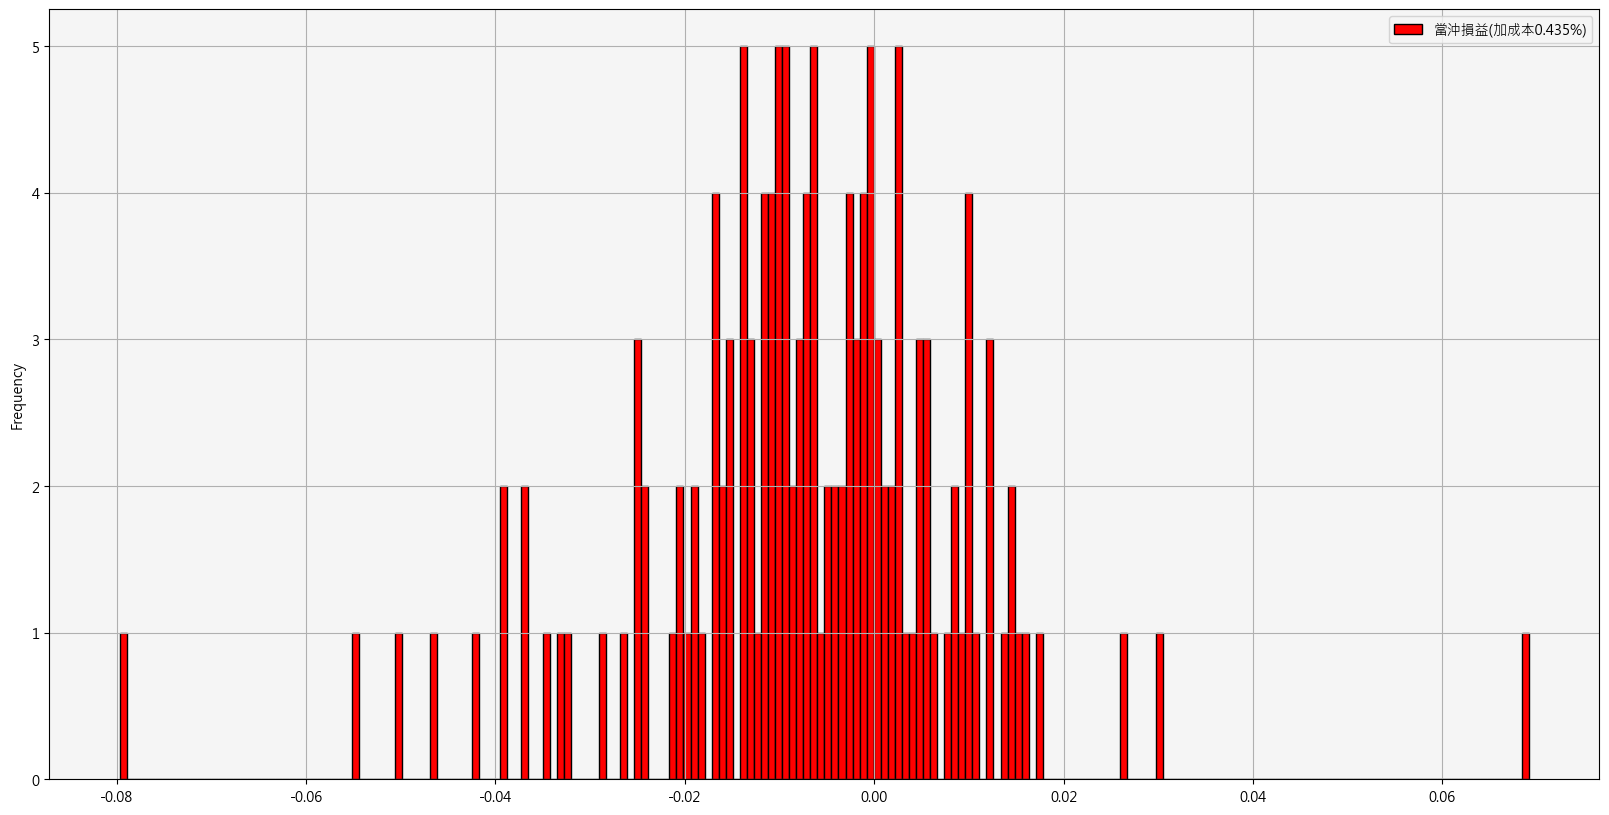

In [173]:
關鍵點買入部位_day[['當沖損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
關鍵點買入部位_day[['當沖損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
關鍵點買入部位_day[['當沖損益(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [174]:
關鍵點買入部位_day[['當沖損益(加成本0.15%)','當沖損益(加成本0.335%)','當沖損益(加成本0.435%)']].describe().iloc[1:,:]

,當沖損益(加成本0.15%),當沖損益(加成本0.335%),當沖損益(加成本0.435%)
mean,-0.004551,-0.006401,-0.007401
std,0.017039,0.017039,0.017039
min,-0.076819,-0.078669,-0.079669
25%,-0.011204,-0.013054,-0.014054
50%,-0.004067,-0.005917,-0.006917
75%,0.004947,0.003097,0.002097
max,0.071994,0.070144,0.069144


<Axes: xlabel='日期'>

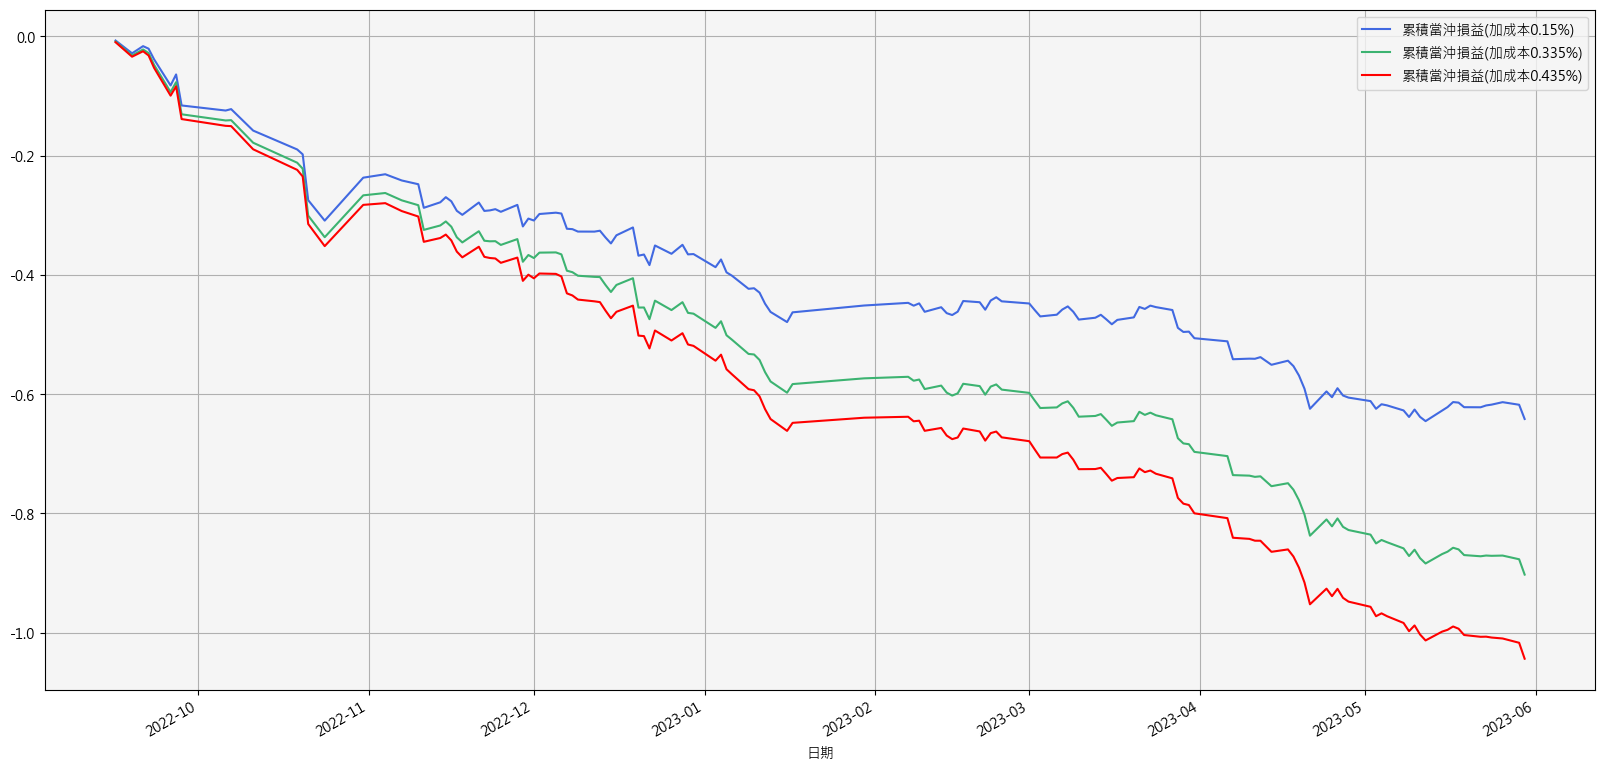

In [175]:
關鍵點買入部位_day[['累積當沖損益(加成本0.15%)','累積當沖損益(加成本0.335%)','累積當沖損益(加成本0.435%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=6>融資</font>**

**<font  size=5>勝率</font>**

In [176]:
pd.concat([pd.DataFrame.from_dict({'勝率':len(融資買入部位[關鍵點買入部位['當沖損益(加成本0.15%)']>0])/len(融資買入部位)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'勝率':len(融資買入部位[融資買入部位['當沖損益(加成本0.335%)']>0])/len(融資買入部位)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'勝率':len(融資買入部位[融資買入部位['當沖損益(加成本0.435%)']>0])/len(融資買入部位)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,勝率
勝率(加成本0.15%),0.394904
勝率(加成本0.335%),0.341561
勝率(加成本0.435%),0.314490


In [178]:
pd.concat([pd.DataFrame.from_dict({'多單每日平均勝率':len(融資買入部位_day[融資買入部位_day['當沖損益(加成本0.15%)']>0])/len(融資買入部位_day)},orient='index').rename(columns={0:'勝率(加成本0.15%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(融資買入部位_day[融資買入部位_day['當沖損益(加成本0.335%)']>0])/len(融資買入部位_day)},orient='index').rename(columns={0:'勝率(加成本0.335%)'}).T,
pd.DataFrame.from_dict({'多單每日平均勝率':len(融資買入部位_day[融資買入部位_day['當沖損益(加成本0.435%)']>0])/len(融資買入部位_day)},orient='index').rename(columns={0:'勝率(加成本0.435%)'}).T])

,多單每日平均勝率
勝率(加成本0.15%),0.400000
勝率(加成本0.335%),0.351724
勝率(加成本0.435%),0.303448


**<font  size=5>每日每股損益分配</font>**

<Axes: ylabel='Frequency'>

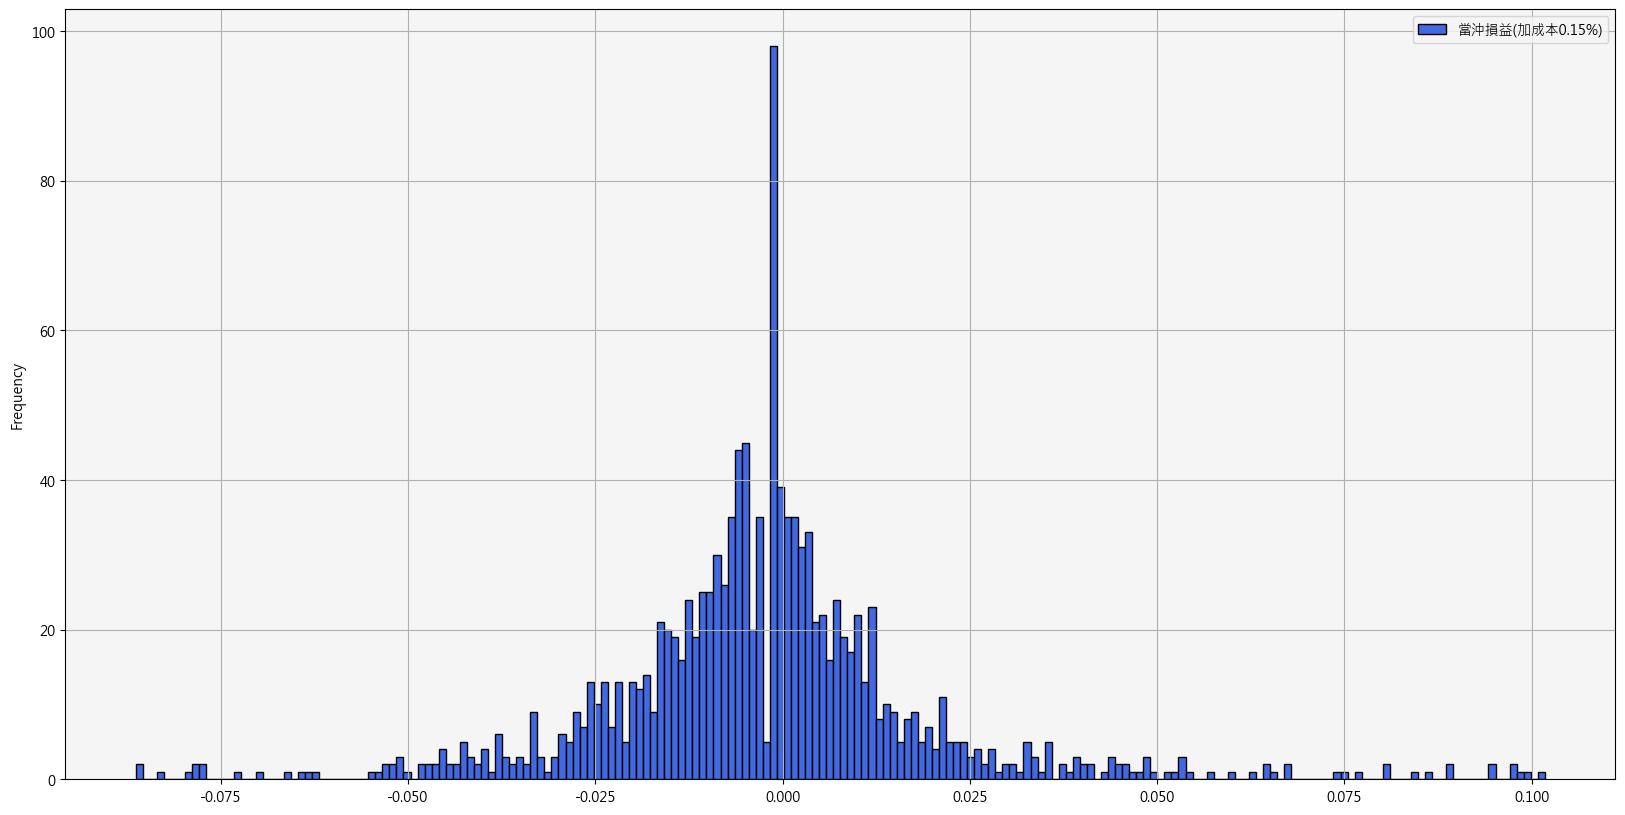

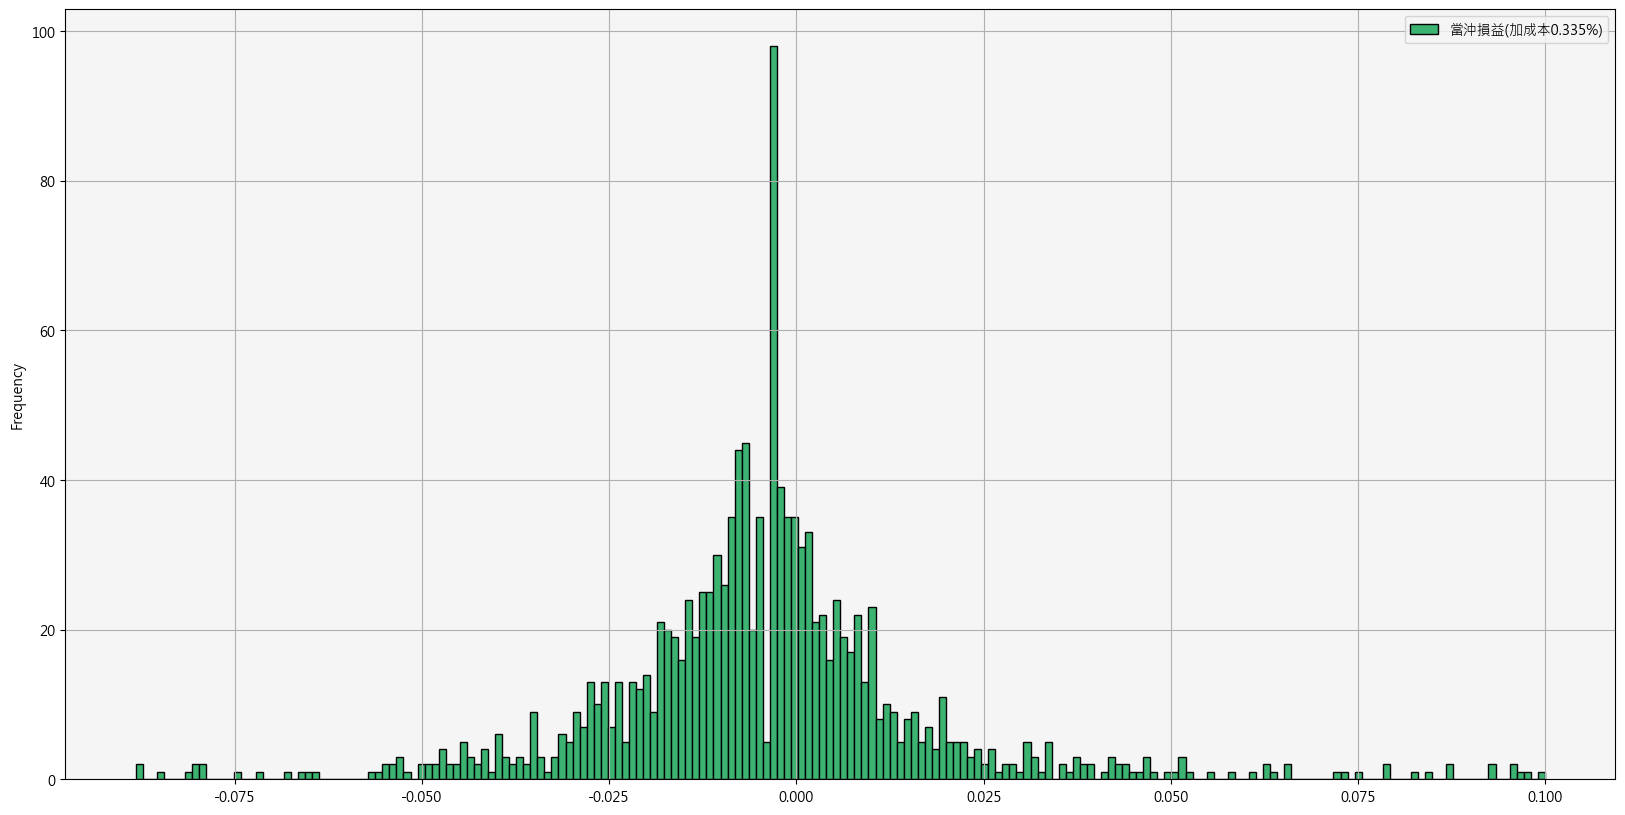

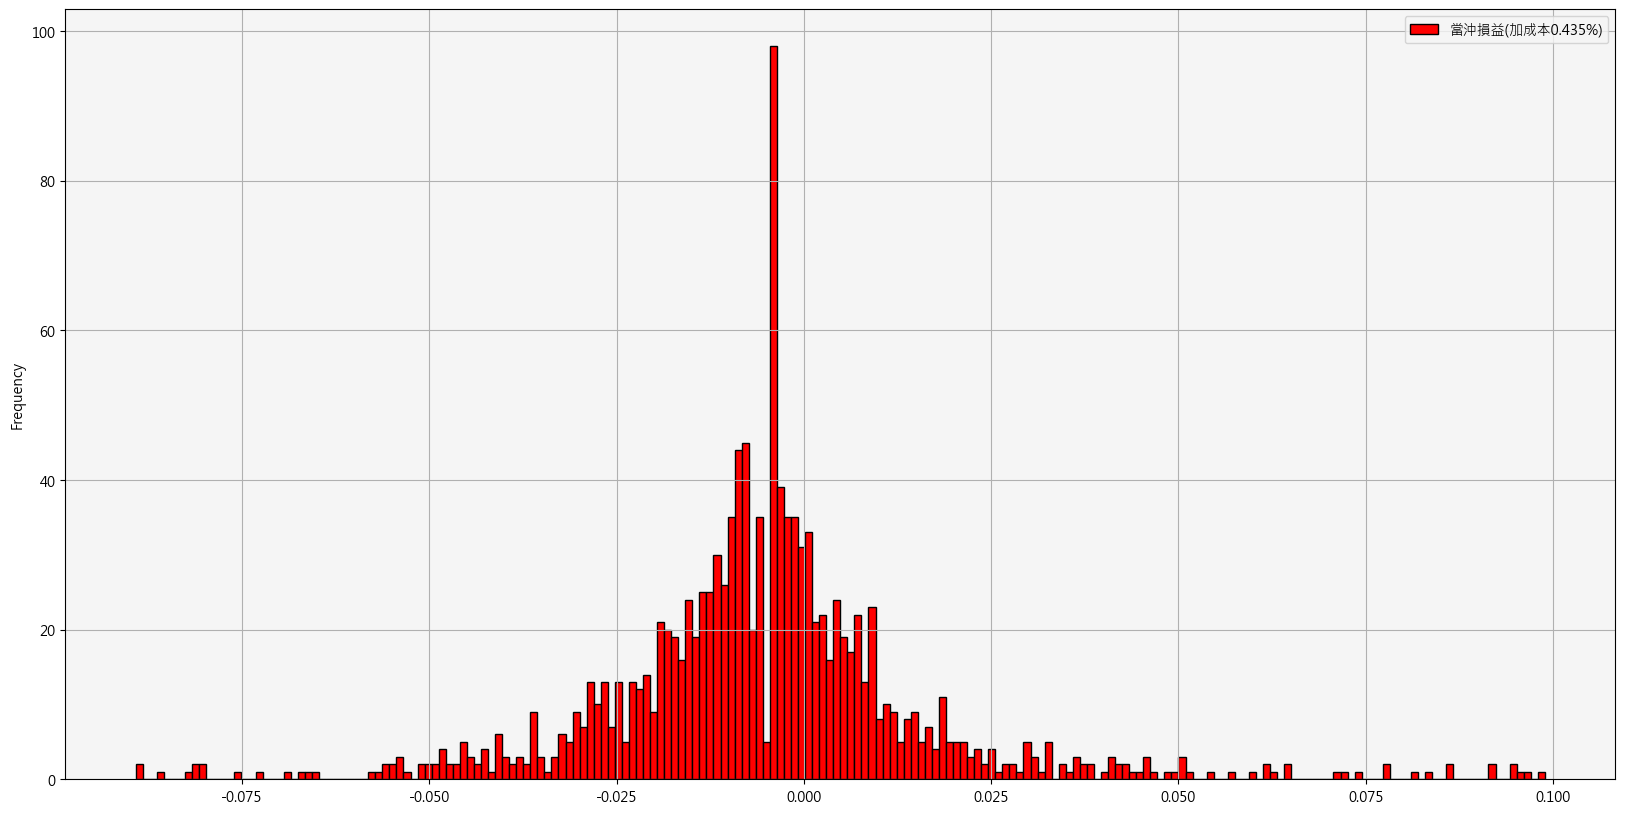

In [179]:
融資買入部位[['當沖損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
融資買入部位[['當沖損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
融資買入部位[['當沖損益(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'red',figsize = (20,10),bins=200,grid = True)

**<font  size=5>每日損益分配</font>**

<Axes: ylabel='Frequency'>

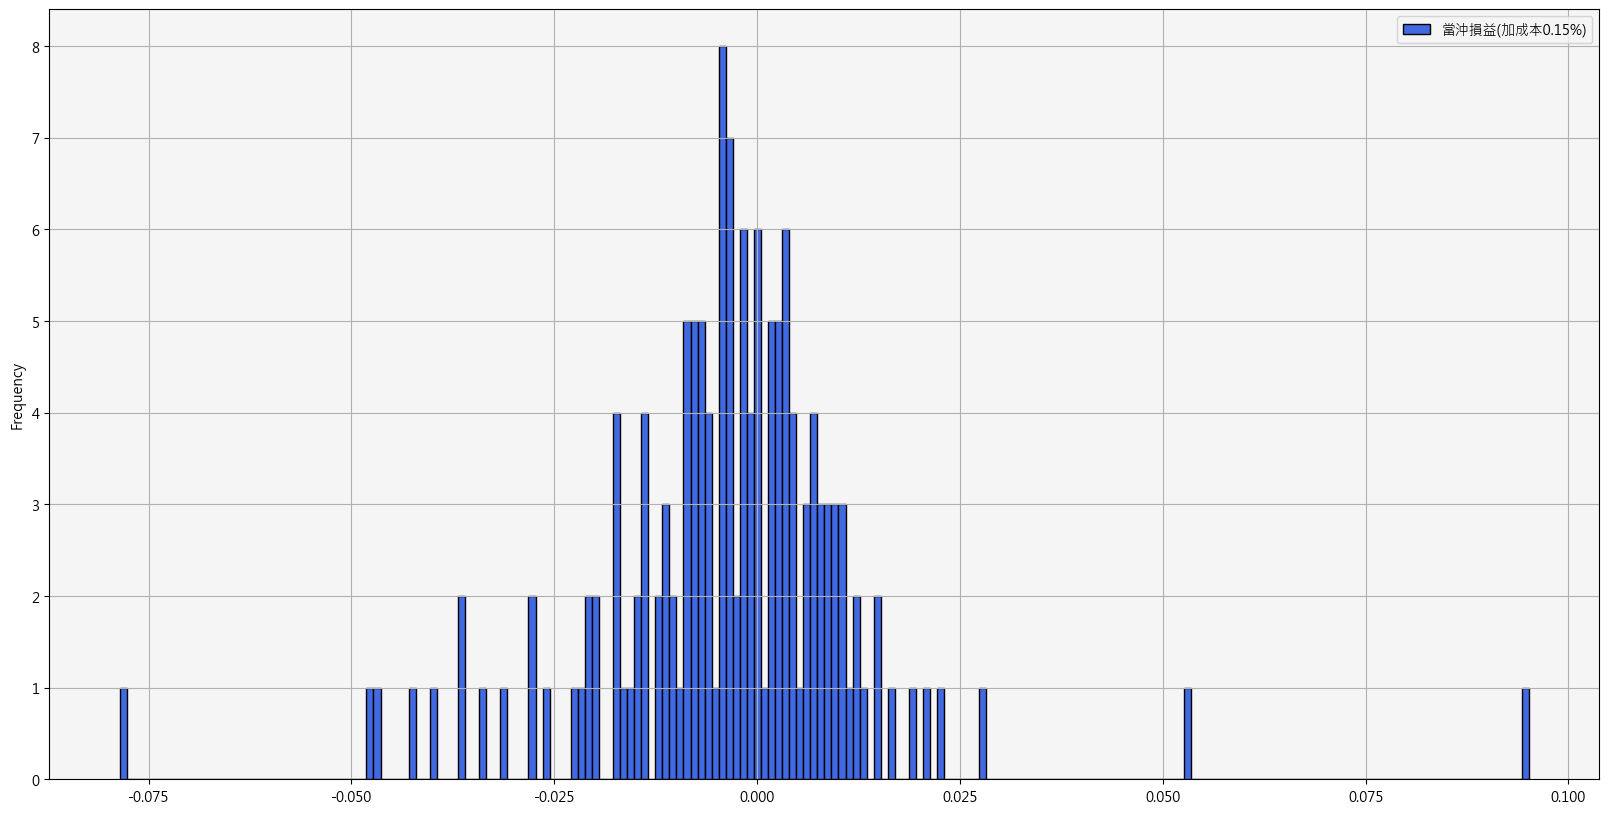

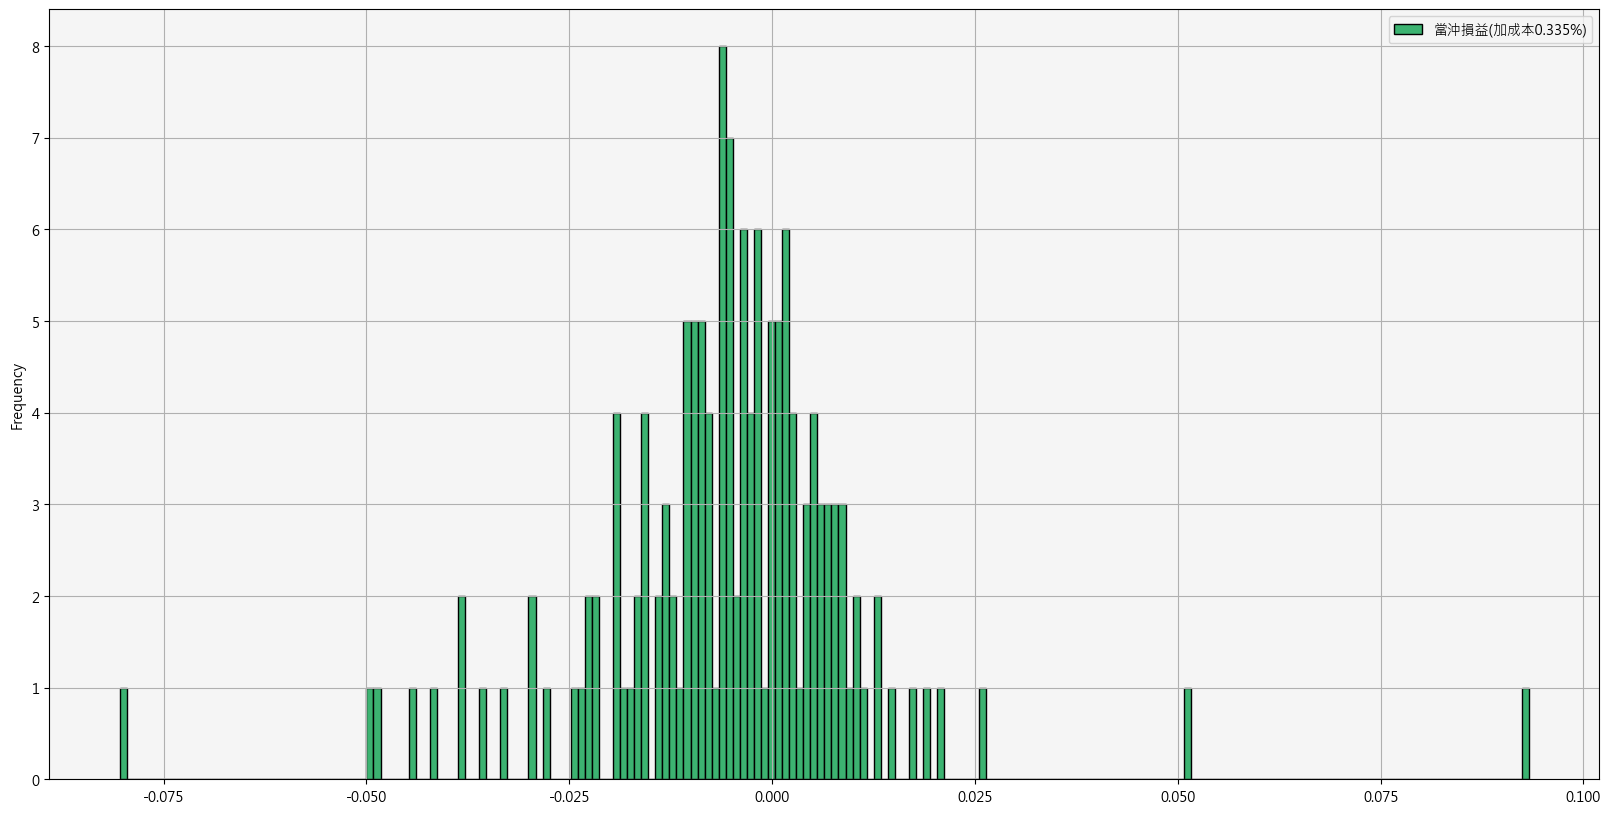

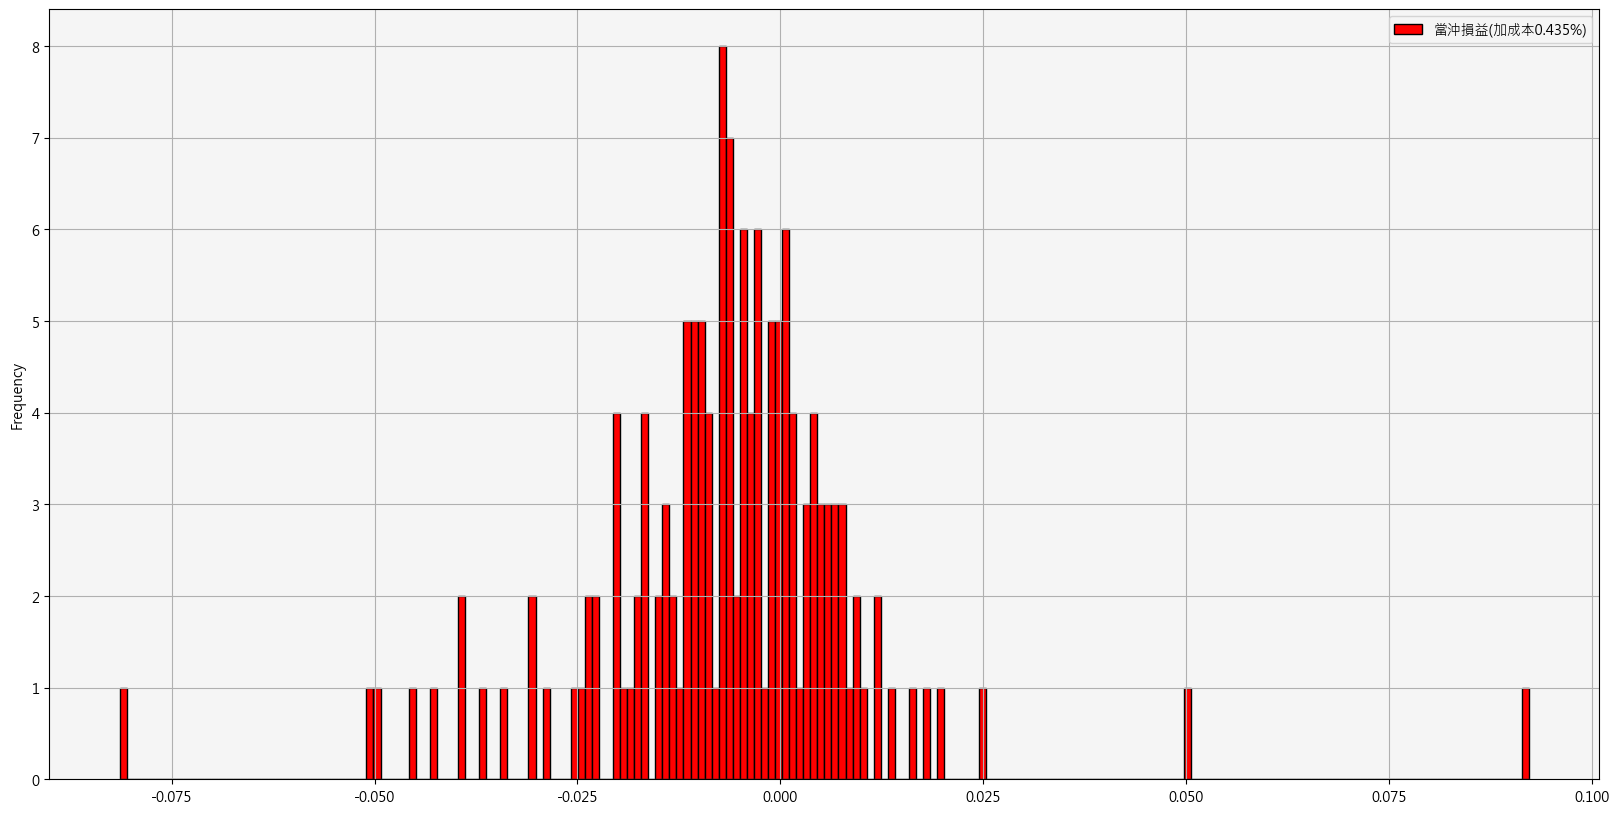

In [180]:
融資買入部位_day[['當沖損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
融資買入部位_day[['當沖損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
融資買入部位_day[['當沖損益(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [181]:
融資買入部位_day[['當沖損益(加成本0.15%)','當沖損益(加成本0.335%)','當沖損益(加成本0.435%)']].describe().iloc[1:,:]

,當沖損益(加成本0.15%),當沖損益(加成本0.335%),當沖損益(加成本0.435%)
mean,-0.003754,-0.005604,-0.006604
std,0.017430,0.017430,0.017430
min,-0.078544,-0.080394,-0.081394
25%,-0.010057,-0.011907,-0.012907
50%,-0.003097,-0.004947,-0.005947
75%,0.003993,0.002143,0.001143
max,0.095139,0.093289,0.092289


<Axes: xlabel='日期'>

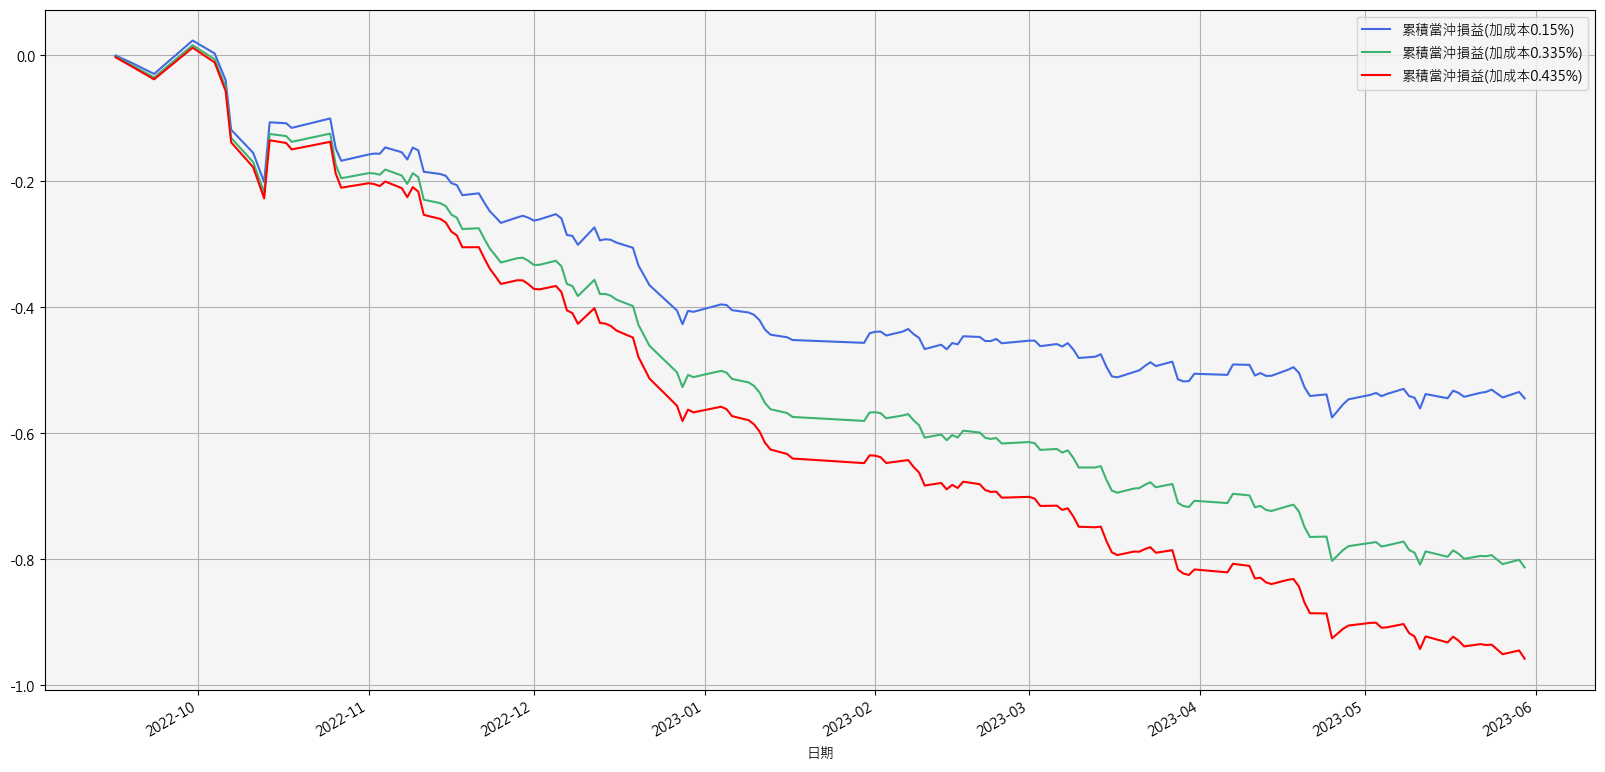

In [182]:
融資買入部位_day[['累積當沖損益(加成本0.15%)','累積當沖損益(加成本0.335%)','累積當沖損益(加成本0.435%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)